**Importing Required Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 150
sns.set_context('talk')
sns.set_style('darkgrid')

**Defining Function for Lorenz Differential Equations**

In [4]:
def lorenz_func(input, output, func_params):
    sigma, r, b = func_params
    x_slope = -sigma*(output[0] - output[1])
    y_slope = r*output[0] - output[1] - output[0]*output[2]
    z_slope = output[0]*output[1] - b*output[2]
    return np.array([x_slope, y_slope, z_slope])

**$\mathbf{4^{th}}$ Order Runge-Kutta Algorithm**

In [5]:
def rk4_step(func, in_old, out_old, step, func_params):
    step2 = step/2.0
    step6 = step/6.0

    k1 = func(in_old, out_old, func_params)
    k2 = func(in_old + step2, out_old + step2*k1, func_params)
    k3 = func(in_old + step2, out_old + step2*k2, func_params)
    k4 = func(in_old + step, out_old + step*k3, func_params)

    return out_old + step6*(k1 + 2.0*k2 + 2.0*k3 + k4)

**Function to Integrate Lorenz Equations**

In [6]:
def get_txyz_lorenz(lorenz_params=[3.0, 17.0, 1.0],
                   init_conditions=[0.0, 1.0, 0.0],
                   step_size=1e-1, start_time=0.0, end_time=50.0):
    #lorenz_params = [sigma, r, b]

    t_array = np.arange(start_time, end_time + step_size, step_size)
    out_array = np.empty((3, len(t_array)))
    out_array[:,0] = init_conditions

    for i in range(1, len(t_array)):
        out_array[:, i] = rk4_step(lorenz_func, t_array[i-1],
                                   out_array[:, i-1], step_size, lorenz_params)

    x_array = out_array[0, :]
    y_array = out_array[1, :]
    z_array = out_array[2, :]

    return t_array, x_array, y_array, z_array

def test_convergence(x, y, z, converge_point=[-4, -4, 16],
                     check_number=-100, sigma=1.0):
    median_point = [np.median(x[check_number:]),
                    np.median(y[check_number:]), np.median(z[check_number:])]
    sigma_vals = [np.std(x[check_number:]),
                  np.std(y[check_number:]), np.std(z[check_number:])]
    status = True
    for i in range(0, 3):
        if np.abs(median_point[i] - converge_point[i]) <= sigma_vals[i]:
            pass
        else:
            status = False
    return status

**Plotting Routines**

In [7]:
def plot_xyz(t, x, y, z, save_name='SHOW', x_label=r'$r=154.5$'):
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True)

    ax1.plot(t, x, label=x_label)
    ax1.set_ylabel(r'$x$')
    
    ax2.plot(t, y)
    ax2.set_ylabel(r'$y$')

    ax3.plot(t, z)
    ax3.set_xlabel(r'$t$')
    ax3.set_ylabel(r'$z$')

    plt.suptitle('Co-ordinate Diagrams')

    if save_name == 'SHOW':
        plt.show()
    elif save_name == 'RETURN':
        return fig, [ax1, ax2, ax3]
    else:
        plt.savefig(save_name)


def plot_phase_space(t, x, y, z, save_name='SHOW'):
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)

    ax1.plot(x, y)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_title(r'$y$ vs $x$')

    ax2.plot(z, y)
    ax2.set_xlabel(r'$z$')
    ax2.set_title(r'$y$ vs $z$')

    plt.suptitle('Phase-Space Diagrams', y=1.02)

    if save_name == 'SHOW':
        plt.show()
    elif save_name == 'RETURN':
        return fig, [ax1, ax2]
    else:
        plt.savefig(save_name)


def plot_power_period(t, periodic_array, periodic_label=r'$x$',
                      upper_limit=None, save_name='SHOW',
                      line_params=['-', r'$r=154.5$']):
    fig, [ax1, ax2] = plt.subplots(2, 1)

    freqs = np.fft.fftfreq(len(t), t[1]-t[0])
    power = (np.abs(np.fft.fft(periodic_array)))**2.0
    power_sort = power[np.argsort(freqs)]
    freq_sort = np.sort(freqs)
    if upper_limit:
        freq_mask = np.where(((freq_sort > 0.0)
                              & (freq_sort < upper_limit)))
    else:
        freq_mask = np.where(freq_sort > 0.0)
    if save_name == 'RETURN':
        ax1.semilogy(freq_sort[freq_mask], power_sort[freq_mask],
                     line_params[0], label=line_params[1])
    else:
        ax1.semilogy(freq_sort[freq_mask], power_sort[freq_mask])
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Power')

    ax2.plot(t, periodic_array)
    ax2.set_xlabel(r'$t$')
    ax2.set_ylabel(periodic_label)

    plt.suptitle('Periodicity Analysis')

    if save_name == 'SHOW':
        plt.show()
    elif save_name == 'RETURN':
        return fig, [ax1, ax2]
    else:
        plt.savefig(save_name)

def plot_poincare_x(t, x, y, z, save_name='SHOW', line_params=[r'$r=154.$']):
    fig = plt.figure()
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    if save_name == 'RETURN':
        plt.scatter(z[zero_crossings],
                    y[zero_crossings], label=line_params[0])
    else:
        plt.scatter(z[zero_crossings], y[zero_crossings])
    plt.xlabel(r'$z$')
    plt.ylabel(r'$y$')
    plt.title(r'$\mathrm{Poincar\'e}$ $\mathrm{Map}$ $\mathrm{for}$ $x=0$')

    if save_name == 'SHOW':
        plt.show()
    elif save_name == 'RETURN':
        return fig
    else:
        plt.savefig(save_name)

***Problem 1:*** **a)** Using $r=1$, $\sigma=3$, $b=1$ for the Lorenz equations at initial conditions $x=z=0$, $y=1$ plot $x(t), y(t), z(t)$ to show that they converge to $[-4, -4, 16]$. Also show the phase-space diagrams for $y(t)$ vs $x(t)$ and $y(t)$ vs $z(t)$. 

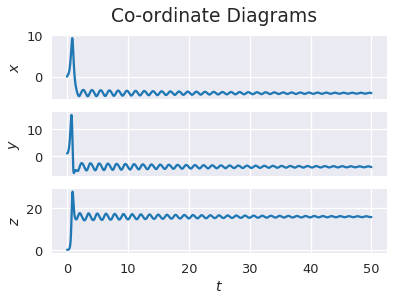

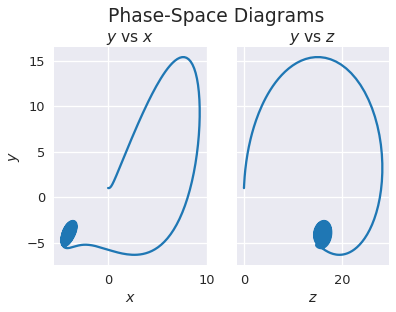

In [8]:
t,x, y, z = get_txyz_lorenz(step_size=1e-2)
plot_xyz(t, x, y, z)
plot_phase_space(t, x, y, z)

***Problem 1:*** **b)** Using different initial conditions, but the same Lorenz parameters, find which  solutions converge to the same stable point as **a)**.

**Finding the Volume of XYZ initial conditions that Converge**

In [9]:
x_vals = np.linspace(-10.0, 10.0, 25)
y_vals = np.copy(x_vals)
z_vals = np.copy(x_vals)
counter = 0
all_coords = list(itertools.product(x_vals, y_vals, z_vals))
status_array = [False]*len(all_coords)
for init_conditions in all_coords:
    t, x, y, z = get_txyz_lorenz(init_conditions=init_conditions)
    status_array[counter] = test_convergence(x, y, z)
    counter += 1

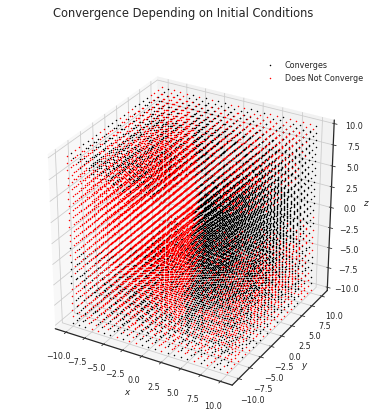

In [10]:
pts = np.array(all_coords)[np.where(status_array)]
pts2 = np.array(all_coords)[np.where(np.invert(status_array))]
sns.set_style('white')
sns.set_context('paper')
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111, projection="3d")
plt.plot(pts[:,0], pts[:,1], pts[:,2], '.k',
         markersize=3, label='Converges')
plt.plot(pts2[:,0], pts2[:,1], pts2[:,2], '.r',
         markersize=3, label='Does Not Converge')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
ax.set_zlabel(r'$z$')
plt.legend(loc='upper right')
plt.suptitle('Convergence Depending on Initial Conditions')
plt.show()

This is not quite as simple as a strict volume where things converge,
but there does seem to be an alternating structure of some sort.

***Problem 2: Repeat the above for $r=26$ to observe the random behavior in the neighborhood of the critical points a) $x=y=5$, $z=25$ and b) $x=y=-5$, $z=25$***

**Critical Point $x=y=5$, $z=25$**

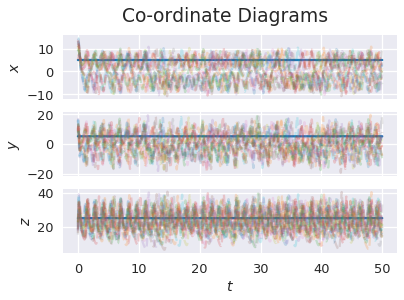

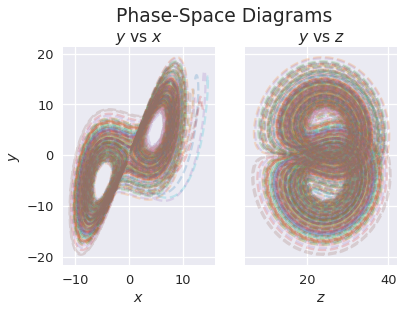

In [11]:
sns.set_context('talk')
sns.set_style('darkgrid')
t,x, y, z = get_txyz_lorenz(lorenz_params=[3.0, 26.0, 1.0],
                            init_conditions=[5.0, 5.0, 25.0], step_size=1e-2)
xyz_fig, [x_ax, y_ax, z_ax] = plot_xyz(t, x, y, z,
                                       save_name='RETURN')
phase_fig, [yx_ax, yz_ax] = plot_phase_space(t, x, y, z,
                                             save_name='RETURN')


for i in range(0, 15):
    eps_random = np.random.uniform([5.0, 5.0, 25.0], [15.0, 15.0, 15.0])
    t_eps, x_eps, y_eps, z_eps = get_txyz_lorenz(lorenz_params=[3.0, 26.0, 1.0],
                                                 init_conditions=eps_random,
                                                 step_size=1e-2)
    x_ax.plot(t_eps, x_eps, '--', alpha=0.2)
    y_ax.plot(t_eps, y_eps, '--', alpha=0.2)
    z_ax.plot(t_eps, z_eps, '--', alpha=0.2)
    yx_ax.plot(x_eps, y_eps, '--', alpha=0.2)
    yz_ax.plot(z_eps, y_eps, '--', alpha=0.2)

**Critical Point $x=y=-5$, $z=25$**

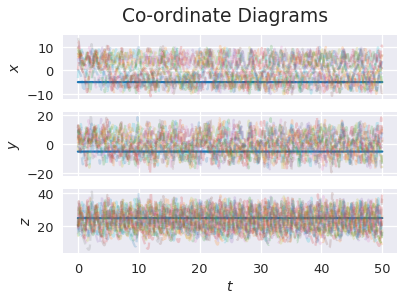

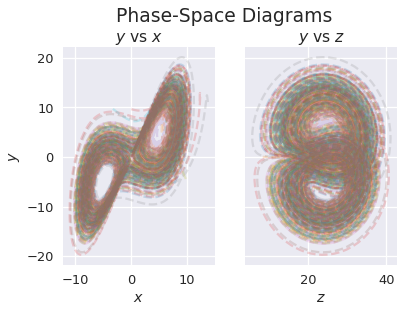

In [12]:
t,x, y, z = get_txyz_lorenz(lorenz_params=[3.0, 26.0, 1.0],
                            init_conditions=[-5.0, -5.0, 25.0], step_size=1e-2)
xyz_fig, [x_ax, y_ax, z_ax] = plot_xyz(t, x, y, z,
                                       save_name='RETURN')
phase_fig, [yx_ax, yz_ax] = plot_phase_space(t, x, y, z,
                                             save_name='RETURN')

for i in range(0, 15):
    eps_random = np.random.uniform([-5.0, -5.0, 25.0],
                                   [15.0, 15.0, 15.0])
    t_eps, x_eps, y_eps, z_eps = get_txyz_lorenz(lorenz_params=[3.0, 26.0, 1.0],
                                                 init_conditions=eps_random,
                                                 step_size=1e-2)
    x_ax.plot(t_eps, x_eps, '--', alpha=0.2)
    y_ax.plot(t_eps, y_eps, '--', alpha=0.2)
    z_ax.plot(t_eps, z_eps, '--', alpha=0.2)
    yx_ax.plot(x_eps, y_eps, '--', alpha=0.2)
    yz_ax.plot(z_eps, y_eps, '--', alpha=0.2)

In both sets of plots above, the solid blue line represents results where the initial condition was equal to the critical point. For each critical point, I did 15 integrations where the initial conditions were drawn from the distribution $\mathcal{N}\left(\mu = \left[\pm5, \pm5, 25\right], \sigma=\left[15, 15, 15\right]\right)$. Keep in mind that all cases use the same values of $\sigma=3$, $r=26$, and $b=1$. The results of these deviated integrations are overlaid on the original plot in faded dashed lines. The critical point stays stationary while the deviations all follow a periodic structure.

Even for those cases where the initial positions were significantly far from the critical point, they converged to the same region in phase space fairly quickly. All these cases settled into orbits with two lobes, where one lobe was much tighter than the other, though which lobe was better constrained seems to depend on whether they fell above or below the line connecting the center of each lobe. Looking at the $y \mathrm{ vs } x$ phase-space plot directly above, for $x=y=-5$ and $z=25$, we see that those cases which started from above and to the left of the line, the lower left lobe was the larger one. If they started below and to the right of the line, the upper left lobe was better constrained instead. Aside from the lobe variation, the greater the original deviation, the larger the orbit amplitude overall.

***Problem 3: Examine one of the period doubling windows discussed in the extract by Sparrow. Be sure to include an integration that lies in the range of noisy periodicity. Amongst the plots you use to illustrate your results include the Poincare diagrams.***

In [13]:
window_low = 148.2
window_high = 166.07
window_mid = 160.0
r_noisy = window_low - 1.5

t_low,x_low, y_low, z_low = get_txyz_lorenz(lorenz_params=[10.0,
                                                           window_low, 8.0/3.0],
                            init_conditions=[-15.0, -15.0, 20.0],
                                            step_size=1e-3)
t_mid,x_mid, y_mid, z_mid = get_txyz_lorenz(lorenz_params=[10.0,
                                                           window_mid, 8.0/3.0],
                            init_conditions=[-15.0, -15.0, 20.0],
                                            step_size=1e-3)
t_high,x_high, y_high, z_high = get_txyz_lorenz(lorenz_params=[10.0,
                                                               window_high, 8.0/3.0],
                            init_conditions=[-15.0, -15.0, 20.0],
                                                step_size=1e-3)
t_noisy,x_noisy, y_noisy, z_noisy = get_txyz_lorenz(lorenz_params=[10.0,
                                                                   r_noisy, 8.0/3.0],
                            init_conditions=[-15.0, -15.0, 20.0],
                                                    step_size=1e-3)

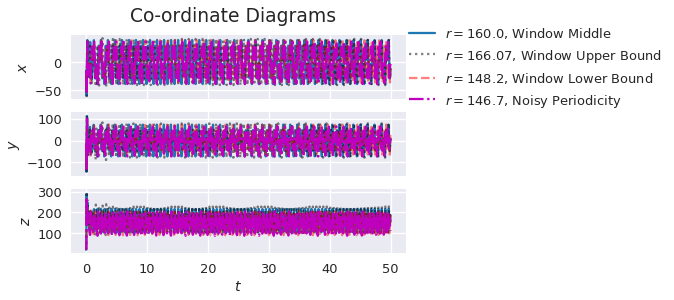

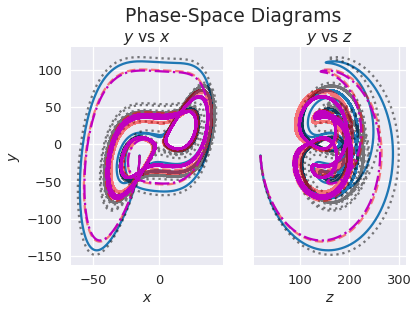

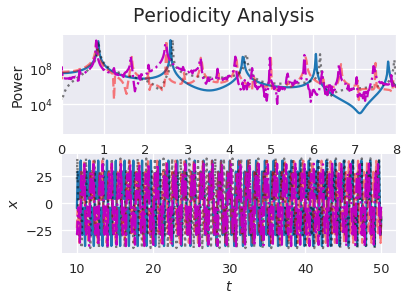

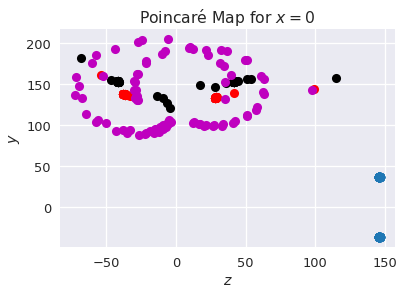

In [14]:
periodic_check = 10000
low_label = r'$r=' + (r'%s' % window_low) + r'$' + r', Window Lower Bound'
mid_label = r'$r=' + (r'%s' % window_mid) + r'$' + r', Window Middle'
high_label = r'$r=' + (r'%s' % window_high) + r'$' + r', Window Upper Bound'
noisy_label = r'$r=' + (r'%s' % r_noisy) + r'$' + r', Noisy Periodicity'

coords_fig, [x_ax, y_ax, z_ax] = plot_xyz(t_mid,
                                          x_mid, y_mid, z_mid,
                                          save_name='RETURN', x_label=mid_label)
phase_fig, [yx_ax, yz_ax] = plot_phase_space(t_mid,
                                             x_mid, y_mid, z_mid,
                                             save_name='RETURN')
period_fig, [power_ax, coord_ax] = plot_power_period(t_mid[periodic_check:],
                                                     x_mid[periodic_check:],
                                                     save_name='RETURN',
                                                    line_params=['-', mid_label])
poincare_fig = plot_poincare_x(t_mid[periodic_check:],
                               x_mid[periodic_check:],
                               y_mid[periodic_check:],
                               z_mid[periodic_check:],
                               save_name='RETURN', line_params=[mid_label])

x_ax.plot(t_high, x_high, ':k', label=high_label, alpha=0.5)
x_ax.plot(t_low, x_low, '--r', label=low_label, alpha=0.5)
x_ax.plot(t_noisy, x_noisy, '-.m', label=noisy_label, alpha=1.0)
x_ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

y_ax.plot(t_high, y_high, ':k', alpha=0.5)
y_ax.plot(t_low, y_low, '--r', alpha=0.5)
y_ax.plot(t_noisy, y_noisy, '-.m', alpha=1.0)

z_ax.plot(t_high, z_high, ':k', alpha=0.5)
z_ax.plot(t_low, z_low, '--r', alpha=0.5)
z_ax.plot(t_noisy, z_noisy,'-.m', alpha=1.0)

yx_ax.plot(x_high, y_high, ':k', alpha=0.5)
yz_ax.plot(z_high, y_high, ':k', alpha=0.5)

yx_ax.plot(x_low, y_low, '--r', alpha=0.5)
yz_ax.plot(z_low, y_low, '--r', alpha=0.5)

yx_ax.plot(x_noisy, y_noisy, '-.m', alpha=1.0)
yz_ax.plot(z_noisy, y_noisy, '-.m', alpha=1.0)

freq_high_unsort = np.fft.fftfreq(len(t_high[periodic_check:]), t_high[1])
freq_low_unsort = np.fft.fftfreq(len(t_low[periodic_check:]), t_low[1])
freq_noisy_unsort = np.fft.fftfreq(len(t_noisy[periodic_check:]), t_noisy[1])

power_high_unsort = (np.abs(np.fft.fft(x_high[periodic_check:])))**2.0
power_low_unsort = (np.abs(np.fft.fft(x_low[periodic_check:])))**2.0
power_noisy_unsort = (np.abs(np.fft.fft(x_noisy[periodic_check:])))**2.0

power_high = power_high_unsort[np.argsort(freq_high_unsort)]
power_low = power_low_unsort[np.argsort(freq_low_unsort)]
power_noisy = power_noisy_unsort[np.argsort(freq_noisy_unsort)]

freq_high = np.sort(freq_high_unsort)
freq_low = np.sort(freq_low_unsort)
freq_noisy= np.sort(freq_noisy_unsort)

power_ax.plot(freq_high, power_high,':k', alpha=0.5)
power_ax.plot(freq_low, power_low, '--r', alpha=0.5)
power_ax.plot(freq_noisy, power_noisy, '-.m', alpha=1.0)

coord_ax.plot(t_high[periodic_check:],
              x_high[periodic_check:],':k', alpha=0.5)
coord_ax.plot(t_low[periodic_check:],
              x_low[periodic_check:], '--r', alpha=0.5)
coord_ax.plot(t_noisy[periodic_check:],
              x_noisy[periodic_check:], '-.m', alpha=1.0)

power_ax.set_xlim(0.0, 8.0)

zero_low = np.where(np.diff(np.signbit(x_low)))[0]
zero_high = np.where(np.diff(np.signbit(x_high)))[0]
zero_noisy = np.where(np.diff(np.signbit(x_noisy)))[0]

poincare_fig.gca().plot(y_high[zero_high],
                        z_high[zero_high], '.k', marker='o')
poincare_fig.gca().plot(y_low[zero_low],
                        z_low[zero_low], '.r', marker='o')
poincare_fig.gca().plot(y_noisy[zero_low],
                        z_noisy[zero_low], '.m', marker='o')

Plotted above are the coordinates, phase-space, power spectra, and Poincare maps for 4 different values of $r$ within or near the $145$ to $160$ window mentioned in Sparrow. The period bifurcation is visible in the power spectra, particularly in the later harmonics where the differences become more significant. The messiness of the *noisy* periodicity case just below the window relative to the other three is apparent in both the power spectrum and Poincare maps.

***Problem 4: Visit some other region or regions of interest that may be suggested by your reading of the extract from Sparrow and report on what you find, using displays that exhibit the interesting behavior***

**Chosen Region**: Spiralling in $z$ behavior for small $b = 0.25$ with $\sigma=10$ and varying values of $ 15.143 > r > 5.6$. Chosen based on reading Sparrow pg 151 - 154.

In [19]:
window_low = 5.6
window_high = 15.143
window_mid = 7.7
r_noisy = 8.0

test_b = 0.25
test_sigma = 10.0

t_low,x_low, y_low, z_low = get_txyz_lorenz(lorenz_params=[test_sigma,
                                                           window_low, test_b],
                            init_conditions=[-15.0, -15.0, 20.0],
                                            step_size=1e-4)
t_mid,x_mid, y_mid, z_mid = get_txyz_lorenz(lorenz_params=[test_sigma,
                                                           window_mid, test_b],
                            init_conditions=[-15.0, -15.0, 20.0],
                                            step_size=1e-4)
t_high,x_high, y_high, z_high = get_txyz_lorenz(lorenz_params=[test_sigma,
                                                               window_high, test_b],
                            init_conditions=[-15.0, -15.0, 20.0],
                                                step_size=1e-4)
t_noisy,x_noisy, y_noisy, z_noisy = get_txyz_lorenz(lorenz_params=[test_sigma,
                                                                   r_noisy, test_b],
                            init_conditions=[-15.0, -15.0, 20.0],
                                                    step_size=1e-4)

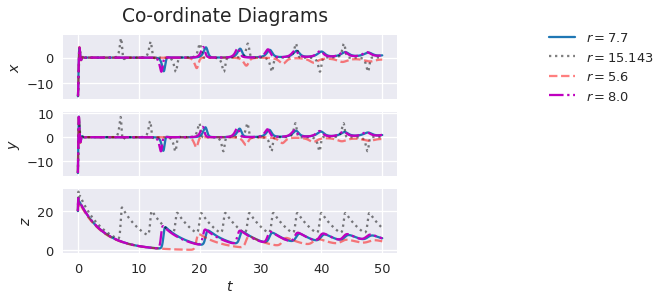

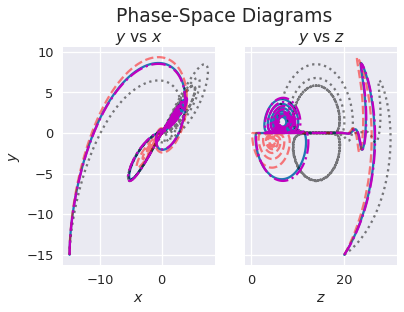

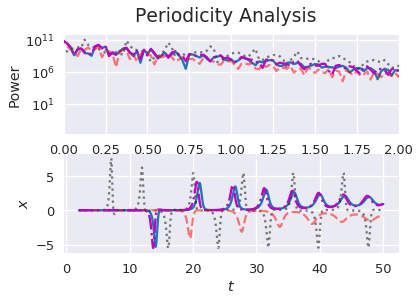

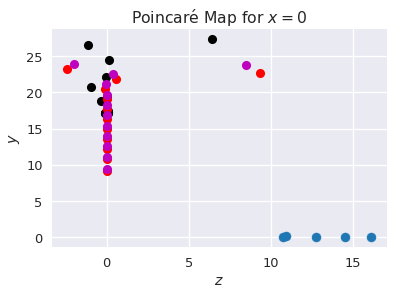

In [20]:
plt.clf()
periodic_check = 20000
low_label = r'$r=' + (r'%s' % window_low) + r'$'
mid_label = r'$r=' + (r'%s' % window_mid) + r'$'
high_label = r'$r=' + (r'%s' % window_high) + r'$'
noisy_label = r'$r=' + (r'%s' % r_noisy) + r'$'

coords_fig, [x_ax, y_ax, z_ax] = plot_xyz(t_mid,
                                          x_mid, y_mid, z_mid,
                                          save_name='RETURN', x_label=mid_label)
phase_fig, [yx_ax, yz_ax] = plot_phase_space(t_mid,
                                             x_mid, y_mid, z_mid,
                                             save_name='RETURN')
period_fig, [power_ax, coord_ax] = plot_power_period(t_mid[periodic_check:],
                                                     x_mid[periodic_check:],
                                                     save_name='RETURN',
                                                    line_params=['-', mid_label])
poincare_fig = plot_poincare_x(t_mid[periodic_check:],
                               x_mid[periodic_check:],
                               y_mid[periodic_check:],
                               z_mid[periodic_check:],
                               save_name='RETURN', line_params=[mid_label])

x_ax.plot(t_high, x_high, ':k', label=high_label, alpha=0.5)
x_ax.plot(t_low, x_low, '--r', label=low_label, alpha=0.5)
x_ax.plot(t_noisy, x_noisy, '-.m', label=noisy_label, alpha=1.0)
x_ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

y_ax.plot(t_high, y_high, ':k', alpha=0.5)
y_ax.plot(t_low, y_low, '--r', alpha=0.5)
y_ax.plot(t_noisy, y_noisy, '-.m', alpha=1.0)

z_ax.plot(t_high, z_high, ':k', alpha=0.5)
z_ax.plot(t_low, z_low, '--r', alpha=0.5)
z_ax.plot(t_noisy, z_noisy,'-.m', alpha=1.0)

yx_ax.plot(x_high, y_high, ':k', alpha=0.5)
yz_ax.plot(z_high, y_high, ':k', alpha=0.5)

yx_ax.plot(x_low, y_low, '--r', alpha=0.5)
yz_ax.plot(z_low, y_low, '--r', alpha=0.5)

yx_ax.plot(x_noisy, y_noisy, '-.m', alpha=1.0)
yz_ax.plot(z_noisy, y_noisy, '-.m', alpha=1.0)

freq_high_unsort = np.fft.fftfreq(len(t_high[periodic_check:]), t_high[1])
freq_low_unsort = np.fft.fftfreq(len(t_low[periodic_check:]), t_low[1])
freq_noisy_unsort = np.fft.fftfreq(len(t_noisy[periodic_check:]), t_noisy[1])

power_high_unsort = (np.abs(np.fft.fft(x_high[periodic_check:])))**2.0
power_low_unsort = (np.abs(np.fft.fft(x_low[periodic_check:])))**2.0
power_noisy_unsort = (np.abs(np.fft.fft(x_noisy[periodic_check:])))**2.0

power_high = power_high_unsort[np.argsort(freq_high_unsort)]
power_low = power_low_unsort[np.argsort(freq_low_unsort)]
power_noisy = power_noisy_unsort[np.argsort(freq_noisy_unsort)]

freq_high = np.sort(freq_high_unsort)
freq_low = np.sort(freq_low_unsort)
freq_noisy= np.sort(freq_noisy_unsort)

power_ax.plot(freq_high, power_high,':k', alpha=0.5)
power_ax.plot(freq_low, power_low, '--r', alpha=0.5)
power_ax.plot(freq_noisy, power_noisy, '-.m', alpha=1.0)

coord_ax.plot(t_high[periodic_check:],
              x_high[periodic_check:],':k', alpha=0.5)
coord_ax.plot(t_low[periodic_check:],
              x_low[periodic_check:], '--r', alpha=0.5)
coord_ax.plot(t_noisy[periodic_check:],
              x_noisy[periodic_check:], '-.m', alpha=1.0)

power_ax.set_xlim(0.0, 2.0)

zero_low = np.where(np.diff(np.signbit(x_low)))[0]
zero_high = np.where(np.diff(np.signbit(x_high)))[0]
zero_noisy = np.where(np.diff(np.signbit(x_noisy)))[0]

poincare_fig.gca().plot(y_high[zero_high],
                        z_high[zero_high], '.k', marker='o')
poincare_fig.gca().plot(y_low[zero_low],
                        z_low[zero_low], '.r', marker='o')
poincare_fig.gca().plot(y_noisy[zero_low],
                        z_noisy[zero_low], '.m', marker='o')

There is clearly periodic structure here, and all the cases qiuckly converge to the $z$-axis as described in Sparrow. But the movements around the axis are not really orbits precisely, just small jumps in each direction that settle back down to the axis. These implulses, visible in the coordinate diagrams, can be on either side of the axis, but are very localized. Looking at the phase diagram, we can see that their magnitude changes significantly and that their position changes depending on $r$. Note that the power spectrum is not particularly strong. Part of this is because of how the impulses are "spiky", approximating delta functions for which the Fourier transform is uniform. These spikes are not well described by single sine-wave solutions and their harmonics, but rather the summation of a broad range of sine-wave frequencies. Since the locations of the spikes are not strictly periodic, and they do not exhibit a constant amplitude, there is no cumulative adding of power at any given frequency.